In [23]:
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from pylab import rcParams
# default values to be used
pd.options.display.max_columns = 100
TOOLS = "hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
from collections import Counter
from numpy import where
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE

import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from imblearn.pipeline import Pipeline as imPipeline
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

In [2]:
df=pd.read_csv("data/Prepared_DF.csv")

In [4]:
X = df.drop(['id', 'status_group', 'status_group_functional', 'status_group_non functional'], axis=1).astype(np.float64)
y = df['status_group']

In [7]:
categorical_cols = [cname for cname in X.columns if 
                    X[cname].dtype == "object"]

numerical_cols = [cname for cname in X.columns if 
                  X[cname].dtype in ['int64', 'float64']]

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', ce.OneHotEncoder(use_cat_names=True))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])
# define model
model = DecisionTreeClassifier()

In [11]:
X = df.drop(['id', 'status_group', 'status_group_functional', 'status_group_non functional'], axis=1).astype(np.float64)
y = df['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initial Training Pipeline

In [12]:
# Create a pipeline that combines the preprocessor with the model
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# split data into training and validation subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Fit the model
my_pipeline.fit(X_train, y_train)
# manual cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = []
for train_index, val_index in kf.split(X_train):
    cv_train_X, cv_val_X = X_train.iloc[train_index], X_train.iloc[val_index]
    cv_train_y, cv_val_y = y_train.iloc[train_index], y_train.iloc[val_index]
    
    my_pipeline.fit(cv_train_X, cv_train_y)
    cv_preds = my_pipeline.predict(cv_val_X)
    cv_score = accuracy_score(cv_val_y, cv_preds)
    cv_scores.append(cv_score)

print("Cross-validation accuracy: %f" % np.mean(cv_scores))
# predict on test data
preds_test = my_pipeline.predict(X_test)
# evaluate the model
test_accuracy = accuracy_score(y_test, preds_test)
print("Test accuracy: %f" % test_accuracy)

Cross-validation accuracy: 0.801635
Test accuracy: 0.807407


In [14]:
# check overfitting or underfitting
if np.mean(cv_scores) < test_accuracy:
    print("The model is likely overfitting")
elif np.mean(cv_scores) > test_accuracy:
    print("The model is likely underfitting")
else:
    print("The model seems well-fitted")

The model is likely overfitting


In [15]:
print("Accuracy:", metrics.accuracy_score(y_test, preds_test))
print("Precision:", metrics.precision_score(y_test, preds_test, average='macro'))
print("Recall:", metrics.recall_score(y_test, preds_test, average='macro'))
print("F1 Score:", metrics.f1_score(y_test, preds_test, average='macro'))

Accuracy: 0.8074074074074075
Precision: 0.7959641236175323
Recall: 0.7961963184634238
F1 Score: 0.7960796552593357


Confusion Matrix:
[[9294 1723]
 [1709 5094]]


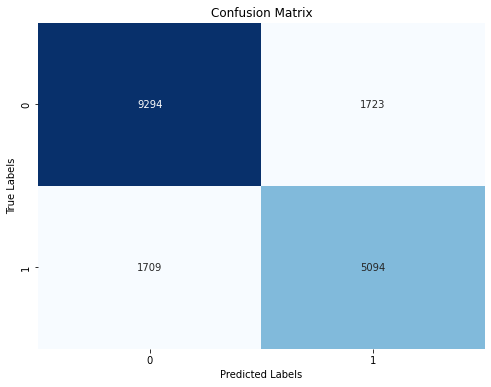

In [16]:
confusion_matrix = metrics.confusion_matrix(y_test, preds_test)
print("Confusion Matrix:")
print(confusion_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Show the plot
plt.show()

In [13]:
roc_curves = []

# Compute ROC curve and ROC area for the first model
preds_test_prob = my_pipeline.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, preds_test_prob[:, 1])
roc_auc = auc(fpr, tpr)
model_name = "Initial DT Model"  # Specify the name of your model

# Store the ROC curve and AUC in the list
roc_curves.append((fpr, tpr, roc_auc, model_name))

In [17]:
# Get feature names
feature_names = my_pipeline.named_steps['preprocessor'].transformers_[0][2] + my_pipeline.named_steps['preprocessor'].transformers_[1][2]

# Fit the model to get feature importances
my_pipeline.fit(X_train, y_train)

# Get feature importances from the 'model' step of the pipeline
importances = my_pipeline.named_steps['model'].feature_importances_

# Sort features by importance
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f): %s" % (f + 1, indices[f], importances[indices[f]], feature_names[indices[f]]))

Feature ranking:
1. feature 269 (0.170450): quantity_group_dry
2. feature 295 (0.082592): waterpoint_type_other
3. feature 310 (0.077196): longitude
4. feature 311 (0.075814): latitude
5. feature 312 (0.047255): wpt_name
6. feature 308 (0.042202): gps_height
7. feature 313 (0.041765): subvillage
8. feature 306 (0.031970): date_recorded
9. feature 305 (0.031541): age
10. feature 317 (0.028010): pop/year
11. feature 314 (0.027150): ward
12. feature 307 (0.020975): funder
13. feature 309 (0.018722): installer
14. feature 0 (0.018639): amount_tsh
15. feature 316 (0.018099): scheme_name
16. feature 178 (0.014067): construction_year
17. feature 318 (0.013986): water_/_person
18. feature 179 (0.011949): extraction_type_gravity
19. feature 293 (0.011716): waterpoint_type_communal standpipe multiple
20. feature 32 (0.011245): region_code
21. feature 315 (0.009834): population
22. feature 33 (0.008386): district_code
23. feature 122 (0.005315): lga_Ngara
24. feature 17 (0.005274): region_Shinyan

# SMOTE Re-Sampling model

In [18]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [21]:
# define resampling with adjusted ratio
resample = SMOTE(sampling_strategy=0.7)  # Adjust the ratio as needed

# define the pipeline with the updated resampling strategy
my_pipeline = imPipeline(steps=[('r', resample),
                                ('preprocessor', preprocessor),
                                ('model', model)])


# manual cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = []

for train_index, val_index in kf.split(X_train):
    cv_train_X, cv_val_X = X_train.iloc[train_index], X_train.iloc[val_index]
    cv_train_y, cv_val_y = y_train.iloc[train_index], y_train.iloc[val_index]
    
    my_pipeline.fit(cv_train_X, cv_train_y)
    cv_preds = my_pipeline.predict(cv_val_X)
    cv_score = accuracy_score(cv_val_y, cv_preds)
    cv_scores.append(cv_score)

print("Cross-validation accuracy: %f" % np.mean(cv_scores))

# predict on test data
preds_test = my_pipeline.predict(X_test)

# evaluate the model
test_accuracy = accuracy_score(y_test, preds_test)
print("Test accuracy: %f" % test_accuracy)

# check overfitting or underfitting
if np.mean(cv_scores) < test_accuracy:
    print("The model is likely overfitting")
elif np.mean(cv_scores) > test_accuracy:
    print("The model is likely underfitting")
else:
    print("The model seems well-fitted")

Cross-validation accuracy: 0.803800
Test accuracy: 0.801122
The model is likely underfitting


In [22]:
# Compute ROC curve and ROC area for the second model
preds_test_prob = my_pipeline.predict_proba(X_test)  # Make sure this is the right pipeline for the second model
fpr, tpr, _ = roc_curve(y_test, preds_test_prob[:, 1])
roc_auc = auc(fpr, tpr)
model_name = "SMOTE Scaled DT Model"  # Specify the name of your model

# Store the ROC curve and AUC in the list
roc_curves.append((fpr, tpr, roc_auc, model_name))


# XGBoost Hyper-Tuning Classifier

In [24]:
# Define a new model
model = XGBClassifier(
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

# Create a new pipeline with XGBoost
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Fit the model
my_pipeline.fit(X_train, y_train)

# Perform cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = []
for train_index, val_index in kf.split(X_train):
    cv_train_X, cv_val_X = X_train.iloc[train_index], X_train.iloc[val_index]
    cv_train_y, cv_val_y = y_train.iloc[train_index], y_train.iloc[val_index]
    
    my_pipeline.fit(cv_train_X, cv_train_y)
    cv_preds = my_pipeline.predict(cv_val_X)
    cv_score = accuracy_score(cv_val_y, cv_preds)
    cv_scores.append(cv_score)

print("Cross-validation accuracy: %f" % np.mean(cv_scores))

# Predict on test data
preds_test = my_pipeline.predict(X_test)

# Evaluate the model
test_accuracy = accuracy_score(y_test, preds_test)
print("Test accuracy: %f" % test_accuracy)

# Check overfitting or underfitting or "perfect"
if np.mean(cv_scores) < test_accuracy:
    print("The model is likely overfitting")
elif np.mean(cv_scores) > test_accuracy:
    print("The model is likely underfitting")
else:
    print("The model seems well-fitted")

Cross-validation accuracy: 0.843723
Test accuracy: 0.844388
The model is likely overfitting


In [ ]:
print("Accuracy:", metrics.accuracy_score(y_test, preds_test))
print("Precision:", metrics.precision_score(y_test, preds_test, average='macro'))
print("Recall:", metrics.recall_score(y_test, preds_test, average='macro'))
print("F1 Score:", metrics.f1_score(y_test, preds_test, average='macro'))

# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, preds_test)
print("Confusion Matrix:")
print(confusion_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Show the plot
plt.show()